# Preprocess Chrome History

In [1]:
import pandas as pd 

In [2]:
chrome_history = pd.read_json('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/History.json', orient='index')

### Most common daily sites i visit

In [17]:
import json
from collections import Counter, defaultdict
from datetime import datetime
from urllib.parse import urlparse

def load_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    browser_history = data.get('Browser History', [])
    # Filter out entries with YouTube URLs
    filtered_history = [entry for entry in browser_history if 'youtube.com' not in entry.get('url', '') and 'youtu.be' not in entry.get('url', '')]
    return filtered_history
    # return data.get('Browser History', [])

def domain_from_url(url):
    try:
        netloc = urlparse(url).netloc
        # strip port, lowercase
        return netloc.split(':')[0].lower()
    except:
        return None

def most_common_sites_daily(history, top_n=5):
    daily_counts = defaultdict(Counter)
    for entry in history:
        ts = entry.get('time_usec')
        url = entry.get('url')
        if ts and url:
            # Chrome’s time_usec is microseconds since Unix epoch
            dt = datetime.utcfromtimestamp(ts / 1e6)
            date_str = dt.date().isoformat()
            domain = domain_from_url(url)
            if domain:
                daily_counts[date_str][domain] += 1

    # For each date, return the top N domains and counts
    return {date: counts.most_common(top_n)
            for date, counts in daily_counts.items()}

history = load_history('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/History.json')
top_sites = most_common_sites_daily(history, top_n=10)
for date in sorted(top_sites):
    print(f"{date}:")
    for domain, count in top_sites[date]:
        print(f"  {domain}: {count}")

2024-04-13:
  arxiv.org: 3
  drops.dagstuhl.de: 1
  qiyanjun.github.io: 1
2024-04-14:
  arxiv.org: 157
  www.google.com: 34
  scholar.google.com: 22
  llms4science-community.github.io: 17
  huggingface.co: 14
  chat.openai.com: 13
  mail.google.com: 7
  www.overleaf.com: 3
  qiyanjun.github.io: 3
  rec.virginia.edu: 2
2024-04-15:
  arxiv.org: 241
  docs.google.com: 30
  canvas.its.virginia.edu: 19
  www.google.com: 13
  virginia.zoom.us: 6
  qiyanjun.github.io: 4
  calebziems.com: 4
  shibidp.its.virginia.edu: 4
  www.forbes.com: 3
  yumeng5.github.io: 3
2024-04-16:
  engineering.cmu.edu: 138
  mail.google.com: 52
  arxiv.org: 22
  www.doa.virginia.gov: 21
  chat.openai.com: 16
  www.google.com: 14
  github.com: 11
  qiyanjun.github.io: 5
  www.overleaf.com: 4
  www.change.org: 3
2024-04-17:
  arxiv.org: 217
  docs.google.com: 106
  openreview.net: 91
  scholar.google.com: 44
  ieeexplore.ieee.org: 25
  www.google.com: 19
  scholar.googleusercontent.com: 10
  chat.openai.com: 10
  soun

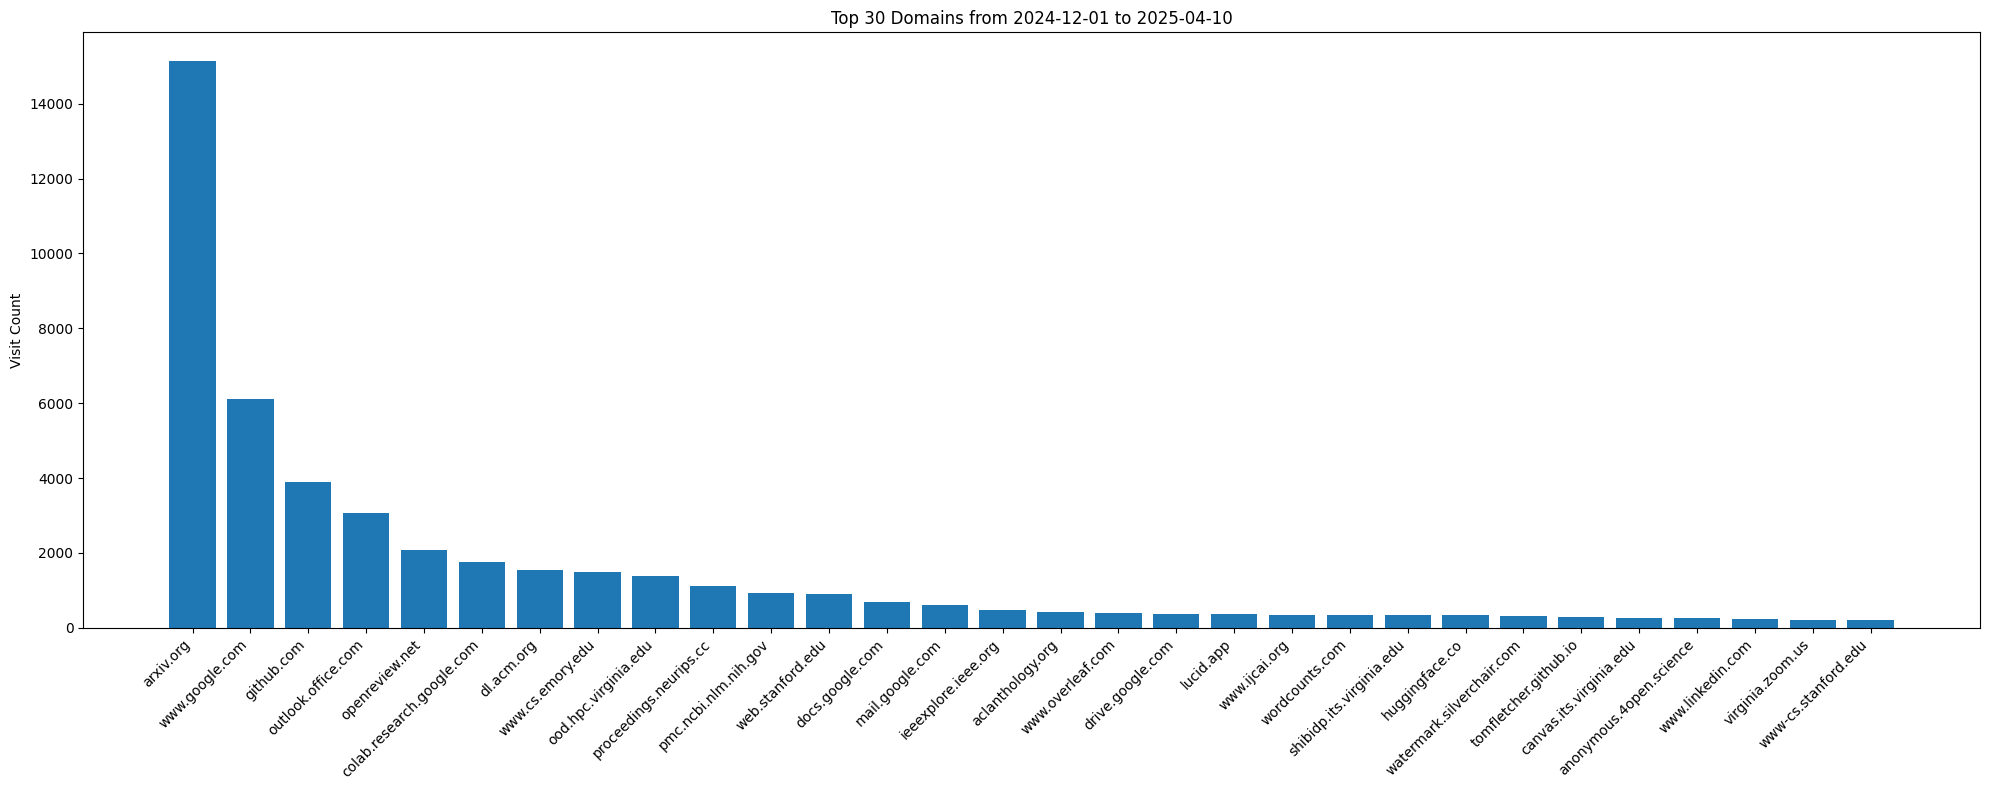

In [18]:
from datetime import datetime, date
import matplotlib.pyplot as plt

def count_domains_between(history, start_date, end_date):
    counts = Counter()
    for entry in history:
        ts = entry.get('time_usec')
        url = entry.get('url')
        if not ts or not url:
            continue

        # Convert Chrome’s microsecond timestamp to a date
        visit_date = datetime.utcfromtimestamp(ts / 1e6).date()

        # Check if in the desired range
        if start_date <= visit_date <= end_date:
            domain = domain_from_url(url)
            counts[domain] += 1

    return counts

def plot_top_domains(counts, n, start_date, end_date):
    top = counts.most_common(n)
    if not top:
        print("No visits in the specified date range.")
        return
    domains, counts_vals = zip(*top)
    plt.figure(figsize=(20, 8))
    plt.bar(domains, counts_vals)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Visit Count')
    plt.title(f'Top {n} Domains from {start_date.isoformat()} to {end_date.isoformat()}')
    plt.tight_layout()
    plt.show()

START_DATE = date(2024, 12, 1)
END_DATE   = date(2025, 4, 10)
TOP_N = 30

domain_counts = count_domains_between(history, START_DATE, END_DATE)
plot_top_domains(domain_counts, TOP_N, START_DATE, END_DATE)


In [6]:
domain_counts

Counter({'arxiv.org': 15150,
         'www.google.com': 6101,
         'github.com': 3888,
         'outlook.office.com': 3061,
         'openreview.net': 2079,
         'colab.research.google.com': 1765,
         'dl.acm.org': 1554,
         'www.cs.emory.edu': 1501,
         'ood.hpc.virginia.edu': 1380,
         'proceedings.neurips.cc': 1115,
         'pmc.ncbi.nlm.nih.gov': 917,
         'web.stanford.edu': 898,
         'docs.google.com': 677,
         'mail.google.com': 612,
         'ieeexplore.ieee.org': 472,
         'aclanthology.org': 415,
         'www.overleaf.com': 406,
         'drive.google.com': 371,
         'lucid.app': 362,
         'www.ijcai.org': 349,
         'wordcounts.com': 343,
         'shibidp.its.virginia.edu': 338,
         'huggingface.co': 331,
         'watermark.silverchair.com': 312,
         'tomfletcher.github.io': 290,
         'canvas.its.virginia.edu': 268,
         'anonymous.4open.science': 256,
         'www.linkedin.com': 240,
         'vi

### Most common sites I visit for life events + 1 days before hand. 
 

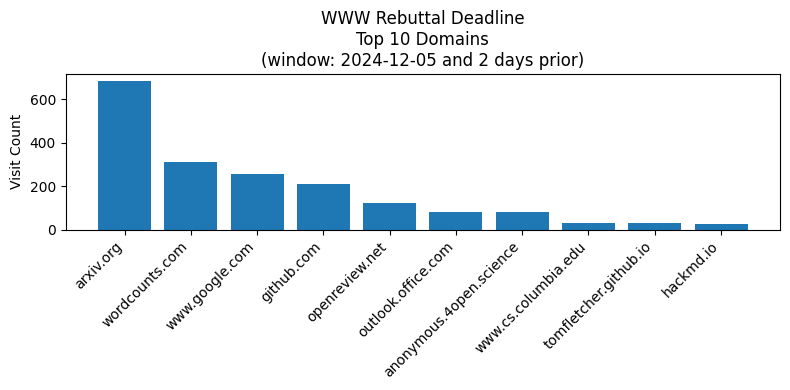

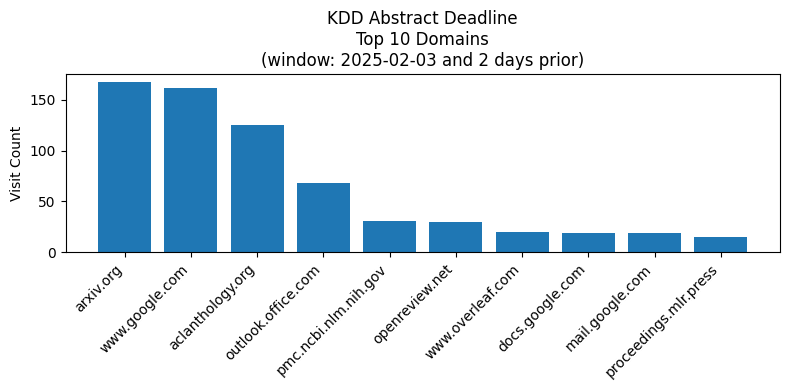

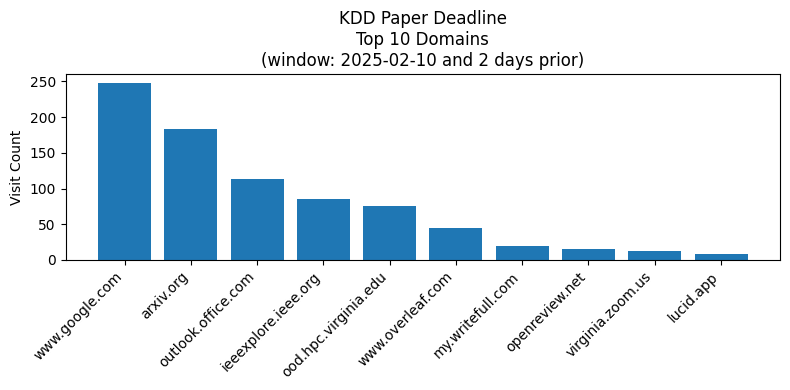

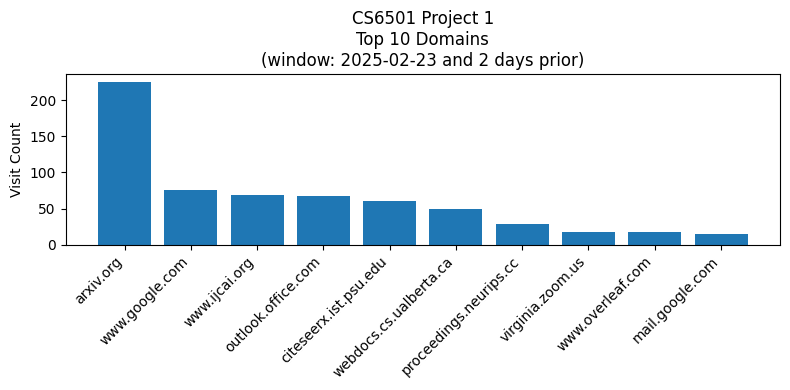

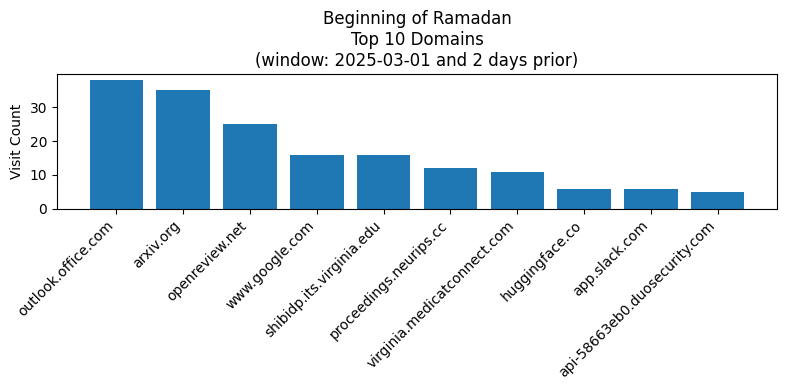

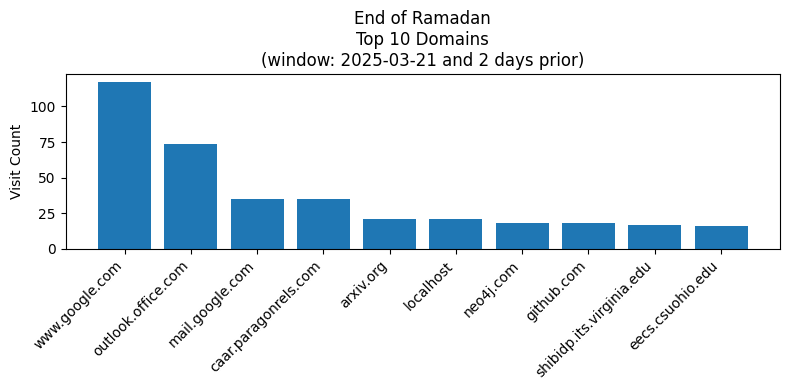

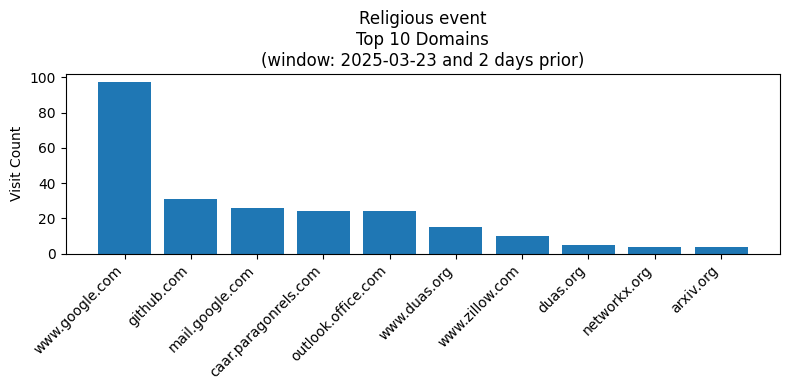

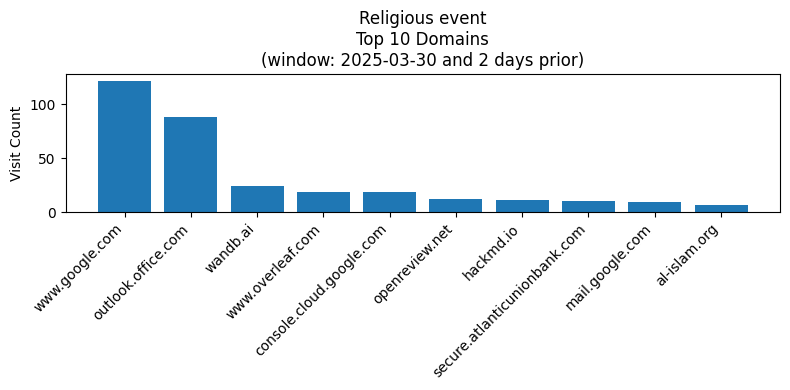

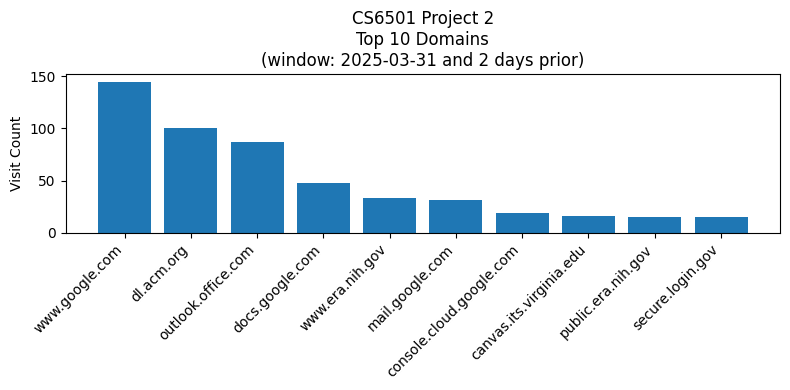

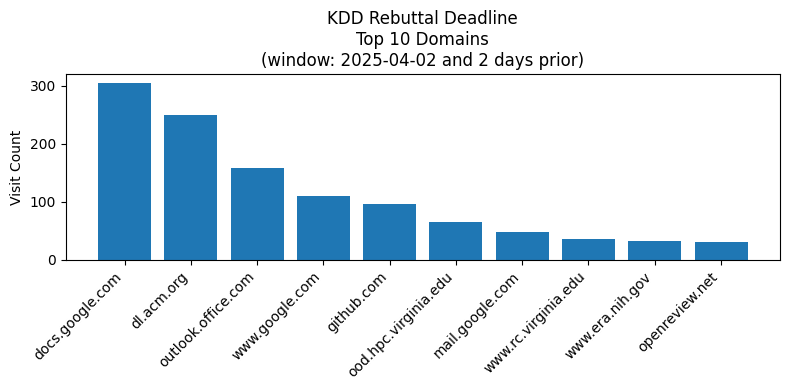

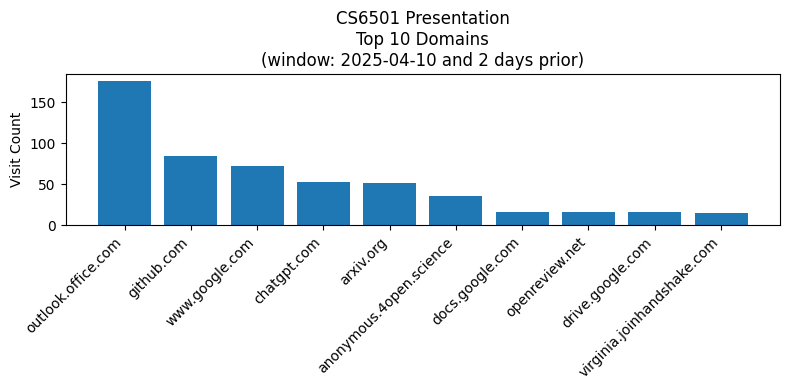

In [7]:
from datetime import datetime, timedelta, date

def most_common_sites_daily(history):
    """
    Returns a dict mapping 'YYYY-MM-DD' -> Counter(domain -> visits on that day).
    """
    daily_counts = defaultdict(Counter)
    for entry in history:
        ts = entry.get('time_usec')
        url = entry.get('url')
        if not ts or not url:
            continue
        dt = datetime.utcfromtimestamp(ts / 1e6)
        day = dt.date().isoformat()
        domain = domain_from_url(url)
        if domain:
            daily_counts[day][domain] += 1
    return daily_counts

def windowed_top_sites(daily_counts, target_dates, buffer_days=2, top_n=5):
    result = {}
    for d in target_dates:
        if isinstance(d, str):
            d = datetime.fromisoformat(d).date()
        window = [(d - timedelta(days=i)).isoformat() for i in range(buffer_days+1)]
        c = Counter()
        for day in window:
            c.update(daily_counts.get(day, Counter()))
        result[d.isoformat()] = c.most_common(top_n)
    return result

daily = most_common_sites_daily(history)

# List your target dates here:
targets = [
    date(2024, 12, 5),
    date(2025, 2, 3),
    date(2025, 2, 10),
    date(2025, 2, 23),
    date(2025, 3, 1),
    date(2025, 3, 21),
    date(2025, 3, 23),
    date(2025, 3, 30),
    date(2025, 3, 31),
    date(2025, 4, 2),
    date(2025, 4, 10),
]

event_titles = [
    "WWW Rebuttal Deadline",
    "KDD Abstract Deadline",
    "KDD Paper Deadline", 
    "CS6501 Project 1",
    "Beginning of Ramadan",
    "End of Ramadan", 
    "Religious event",
    "Religious event",
    "CS6501 Project 2",
    "KDD Rebuttal Deadline",
    "CS6501 Presentation"
]


top_n = 10

top_sites = windowed_top_sites(daily, targets, buffer_days=2, top_n=top_n)

for date_obj, title in zip(targets, event_titles):
    key = date_obj.isoformat()
    sites = top_sites.get(key, [])
    if not sites:
        print(f"No data for {title} ({key})")
        continue

    domains, counts = zip(*sites)
    plt.figure(figsize=(8, 4))
    plt.bar(domains, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{title}\nTop {top_n} Domains\n(window: {key} and 2 days prior)")
    plt.ylabel("Visit Count")
    plt.tight_layout()

plt.show()

In [ ]:
# chrome_history = chrome_history.T
# chrome_history = chrome_history['Browser History']
# chrome_history = pd.DataFrame(chrome_history.tolist())
# from urllib.parse import urlparse

# # --- Step 1: Convert timestamps and filter by date ---
# # Convert 'time_usec' to datetime
# chrome_history['time_usec'] = pd.to_datetime(chrome_history['time_usec'])

# # Filter to include only the last 6 months of data
# six_months_ago = pd.Timestamp.now() - pd.DateOffset(months=6)
# chrome_history_recent = chrome_history[chrome_history['time_usec'] >= six_months_ago].copy()

# # --- Step 2: Exclude YouTube-related entries ---
# # Remove rows where the URL contains 'youtube.com' or 'youtu.be'
# chrome_history_recent = chrome_history_recent[~chrome_history_recent['url'].str.contains(r"youtube\.com|youtu\.be", case=False, na=False)]

# # --- Step 3: Estimate session durations ---
# # Sort by timestamp
# chrome_history_recent = chrome_history_recent.sort_values(by='time_usec')

# # Compute time differences between consecutive events
# chrome_history_recent['time_diff'] = chrome_history_recent['time_usec'].diff()

# # Define a threshold (e.g., 30 minutes) to cap continuous browsing gaps
# threshold = pd.Timedelta(minutes=30)
# chrome_history_recent['session_duration'] = chrome_history_recent['time_diff'].apply(lambda x: x if pd.notnull(x) and x <= threshold else pd.Timedelta(0))

# # Create a new column for the date (dropping the time)
# chrome_history_recent['date'] = chrome_history_recent['time_usec'].dt.date

# # --- Step 4: Extract domain names ---
# def extract_domain(url):
#     try:
#         parsed = urlparse(url)
#         return parsed.netloc
#     except Exception:
#         return None

# chrome_history_recent['domain'] = chrome_history_recent['url'].apply(extract_domain)

# # --- Step 5: Aggregate overall daily Chrome time ---
# daily_chrome_time = chrome_history_recent.groupby('date')['session_duration'].sum().reset_index()
# daily_chrome_time['chrome_time_minutes'] = daily_chrome_time['session_duration'].dt.total_seconds() / 60

# # --- Step 6: Compute top 5 sites per day based on time spent ---
# # Group by date and domain to sum the session durations for each site
# domain_daily = chrome_history_recent.groupby(['date', 'domain'])['session_duration'].sum().reset_index()
# domain_daily['duration_seconds'] = domain_daily['session_duration'].dt.total_seconds()

# # Define a function to extract the top 5 domains for a given date
# def top_5_sites_for_date(date):
#     daily_data = domain_daily[domain_daily['date'] == date]
#     sorted_domains = daily_data.sort_values(by='duration_seconds', ascending=False)
#     # Return a list of the top 5 domain names (if less than 5, it will return whatever is available)
#     top_domains = list(sorted_domains['domain'].head(5))
#     return top_domains

# # Apply the function to each date
# daily_chrome_time['top_5_sites'] = daily_chrome_time['date'].apply(top_5_sites_for_date)



In [24]:
chrome_history_recent

,favicon_url,page_transition_qualifier,title,url,time_usec,client_id,time_diff,session_duration,date,domain


In [ ]:
daily_chrome_time

# Preprocess YouTube History

In [1]:
import json
from datetime import datetime, date, timedelta
from collections import defaultdict

# Load the JSON file
with open('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/watch-history.json', 'r') as f:
    watch_data = json.load(f)

# Define custom date range
start_date = date(2024, 11, 30)
end_date = date(2025, 4, 1)  # inclusive

# Count videos watched each day
daily_counts = defaultdict(int)

for entry in watch_data:
    time_str = entry.get('time')
    if time_str:
        dt = datetime.fromisoformat(time_str.replace('Z', '+00:00'))
        watch_day = dt.date()
        if start_date <= watch_day <= end_date:
            daily_counts[watch_day.isoformat()] += 1

# Print results sorted by date
for day in sorted(daily_counts.keys()):
    print(f"{day}: {daily_counts[day]} videos watched")

2024-11-30: 238 videos watched
2024-12-01: 147 videos watched
2024-12-02: 99 videos watched
2024-12-03: 78 videos watched
2024-12-04: 321 videos watched
2024-12-05: 231 videos watched
2024-12-06: 161 videos watched
2024-12-07: 219 videos watched
2024-12-08: 341 videos watched
2024-12-09: 323 videos watched
2024-12-10: 515 videos watched
2024-12-11: 815 videos watched
2024-12-12: 270 videos watched
2024-12-13: 209 videos watched
2024-12-14: 39 videos watched
2024-12-15: 442 videos watched
2024-12-16: 479 videos watched
2024-12-17: 366 videos watched
2024-12-18: 578 videos watched
2024-12-19: 244 videos watched
2024-12-20: 423 videos watched
2024-12-21: 260 videos watched
2024-12-22: 304 videos watched
2024-12-23: 497 videos watched
2024-12-24: 647 videos watched
2024-12-25: 596 videos watched
2024-12-26: 102 videos watched
2024-12-27: 299 videos watched
2024-12-28: 315 videos watched
2024-12-29: 186 videos watched
2024-12-30: 195 videos watched
2024-12-31: 76 videos watched
2025-01-01: 

In [19]:
import json
import pandas as pd
from collections import Counter, defaultdict
from datetime import datetime, date, timedelta
from urllib.parse import urlparse

def load_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    browser_history = data.get('Browser History', [])
    # Filter out entries with YouTube URLs
    filtered_history = [entry for entry in browser_history if 'youtube.com' not in entry.get('url', '') and 'youtu.be' not in entry.get('url', '')]
    return filtered_history
    # return data.get('Browser History', [])


domain_type_map = {
    'doc.google.com':   'class_work',
    'drive.google.com': 'class_work',
    'canvas.virginia.edu': 'class_work',
    'tomflectcher.github.io': 'class_work',
    'outlook.office.com': 'reserach(explore)',
    'outlook.office.com': 'reserach(dev)',
    'outlook.office.com': 'class_work',
    'lucid.app': 'research(dev)',
    'openreview.net': 'research(dev)',
    'huggingface.co': 'research(dev)',
    'ood.hpc.virginia.edu': 'research(dev)',
    'overleaf.com': 'research(dev)',
    'anonymous.4open.science': 'research(dev)',
    'colab.research.google.com': 'research(dev)',
    'wordcounts.com': 'research(dev)',
    'www.google.com':    'research(explore)',
    'web.stanford.edu': 'research(explore)',
    'ieeexplore.ieee.org': 'research(explore)',
    'github.com':     'research(explore)',
    'arxiv.org':     'research(explore)',
    'dl.acm.org':   'research(explore)',
    'pmc.ncbi.nlm.nih.gov': 'research(explore)',
    'www.cs.emory.edu': 'research(explore)',
    'proceedings.neurips.cc': 'research(explore)',
    'aclanthology.org': 'research(explore)',
    'ijcai.org': 'research(explore)',
}


def domain_from_url(url):
    netloc = urlparse(url).netloc
    return netloc.split(':')[0].lower()

def site_type_from_domain(domain):
    # fallback to 'other' if domain not in your map
    return domain_type_map.get(domain, 'other')

def most_common_site_types_daily(history, start_date, end_date):
    """
    Returns a dict mapping 'YYYY-MM-DD' -> Counter(site_type -> visits on that day).
    """
    daily_type_counts = defaultdict(Counter)
    for entry in history:
        ts  = entry.get('time_usec')
        url = entry.get('url')
        if ts and url:
            dt = datetime.utcfromtimestamp(ts / 1e6)
            day = dt.date()
            if start_date <= day <= end_date:
                domain = domain_from_url(url)
                site_type = site_type_from_domain(domain)
                daily_type_counts[day.isoformat()][site_type] += 1

    return daily_type_counts



def load_watch_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def youtube_videos_watched_daily(watch_history, start_date, end_date):
    daily_counts = defaultdict(int)
    for entry in watch_history:
        time_str = entry.get('time')
        if time_str:
            dt = datetime.fromisoformat(time_str.replace('Z', '+00:00'))
            watch_day = dt.date()
            if start_date <= watch_day <= end_date:
                daily_counts[watch_day.isoformat()] += 1
    return daily_counts

# Define custom date range
start_date = date(2024, 12, 3)
end_date = date(2025, 4, 11)  # inclusive

# Load Chrome history and YouTube watch history
chrome_history = load_history('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/History.json')
youtube_history = load_watch_history('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/watch-history.json')

# Get daily stats
# chrome_top_sites = most_common_sites_daily(chrome_history, start_date=start_date, end_date=end_date, top_n=10)
chrome_site_types = most_common_site_types_daily(
    chrome_history,
    start_date=start_date,
    end_date=end_date
)
youtube_daily_counts = youtube_videos_watched_daily(youtube_history, start_date, end_date)

# Combine data into a DataFrame
all_dates = set(chrome_site_types.keys()).union(youtube_daily_counts.keys())
# all_dates = set(chrome_top_sites.keys()).union(youtube_daily_counts.keys())
# data = []

# for date in sorted(all_dates):
#     youtube_count = youtube_daily_counts.get(date, 0)    
#     chrome_visits = sum(count for _, count in chrome_top_sites.get(date, []))
#     top_sites = chrome_top_sites.get(date, [])
#     data.append({
#         'date': date,
#         'youtube_videos_watched': youtube_count,
#         'chrome_visits': chrome_visits,
#         'top_sites': top_sites
#     })

# df = pd.DataFrame(data)


data = []
for day in sorted(all_dates):
    youtube_count = youtube_daily_counts.get(day, 0)
    # sum of all chrome visits that day
    chrome_visits = sum(chrome_site_types.get(day, {}).values())
    # and record the full type‐counts
    site_types = chrome_site_types.get(day, {})
    data.append({
        'date': day,
        'youtube_videos_watched': youtube_count,
        'chrome_visits': chrome_visits,
        'site_types': list(site_types.items())
    })

df = pd.DataFrame(data)

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
from scipy.stats import pointbiserialr
from statsmodels.tsa.stattools import ccf
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# --- assume df already loaded with columns:
#     date | youtube_videos_watched | chrome_visits | site_types | (events one-hots) …

# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date').sort_index()
df.index = pd.to_datetime(df.index)
df = df.sort_index()
# (events code unchanged…)

# --- your existing event lists ---
targets = [
    date(2024, 12, 5),
    date(2025, 2, 3),
    date(2025, 2, 10),
    date(2025, 2, 23),
    date(2025, 3, 1),
    date(2025, 3, 21),
    date(2025, 3, 23),
    date(2025, 3, 30),
    date(2025, 3, 31),
    date(2025, 4, 2),
    date(2025, 4, 10),
]
event_titles = [
    "WWW Rebuttal Deadline",
    "KDD Abstract Deadline",
    "KDD Paper Deadline",
    "CS6501 Project 1",
    "Beginning of Ramadan",
    "Religious event",
    "Religious event",
    "CS6501 Project 2",
    "End of Ramadan",
    "CS6501 Presentation",
    "KDD Rebuttal Deadline",
]
event_types = [
    "academic","academic","academic",
    "academic","personal","personal",
    "personal","academic","personal",
    "academic","academic"
]

# --- 2. Data Preparation ---
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# Build events DataFrame for your listed targets
events = pd.DataFrame({
    'date': pd.to_datetime(targets),
    'event_title': event_titles,
    'event_type': event_types
}).set_index('date')

# --- NEW: Add every Thursday as an academic event ---
# Generate all Thursdays in the span of your data
thursdays = pd.date_range(start=df.index.min(),
                          end=df.index.max(),
                          freq='W-THU').normalize()

# Create a DataFrame of those Thursdays
events_th = pd.DataFrame({
    'event_title': ['Advisor Meeting'] * len(thursdays),
    'event_type':  ['academic'] * len(thursdays)
}, index=thursdays)

# Combine, but don’t overwrite any specific events you already defined:
events = pd.concat([
    events,
    events_th[~events_th.index.isin(events.index)]
])

# Now join events back into your main df
df = df.join(events, how='left')

# One-hot encode event_title and event_type
df = pd.concat([
    df,
    pd.get_dummies(df['event_title'], prefix='ev'),
    pd.get_dummies(df['event_type'], prefix='type')
], axis=1).fillna(0)

# === NEW: Expand site_types into separate columns ===
#  each df['site_types'] value is e.g. [('social', 12), ('news', 3), …]

# 1) find every unique site_type in your period
all_types = df['site_types'].explode().dropna().apply(lambda x: x[0])
unique_types = all_types.unique().tolist()

# 2) helper to map a list of (type,count) → { type: count, … }
def mk_type_dict(lst):
    d = dict(lst or [])  # handle NaN or empty
    return {t: d.get(t, 0) for t in unique_types}

# 3) build a DataFrame of those counts
type_counts = df['site_types'].apply(mk_type_dict).apply(pd.Series)

# 4) concat back into df
df = pd.concat([df, type_counts], axis=1)






Point-biserial corr (academic vs YouTube): r=-0.158, p=0.073
Point-biserial corr (academic vs Chrome):  r=-0.088, p=0.319


## Exploritory Visual:

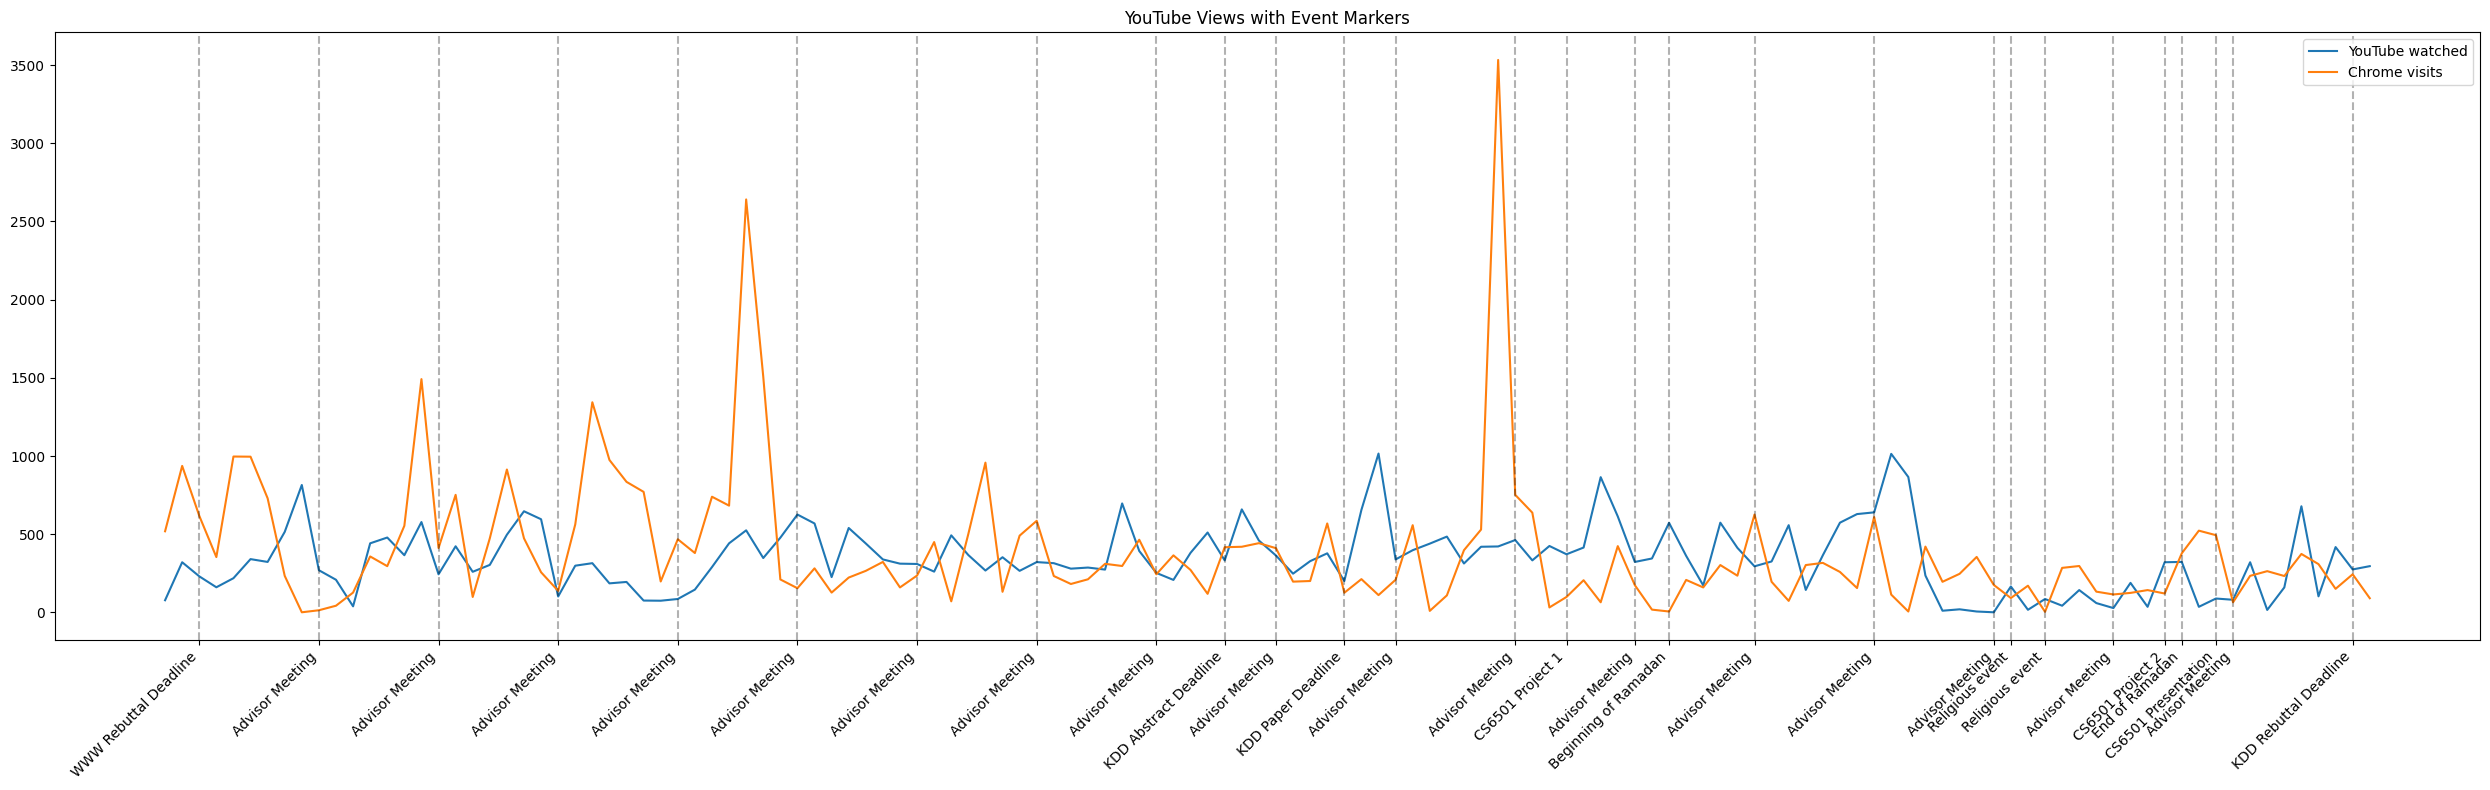

In [54]:
plt.figure(figsize=(25,8))
plt.plot(df.index, df['youtube_videos_watched'], label='YouTube watched')
plt.plot(df.index, df['chrome_visits'], label='Chrome visits')

# Add vertical lines for events
for ev in events.index:
    plt.axvline(ev, color='k', linestyle='--', alpha=0.3)

# Set x-ticks to event dates and titles
plt.xticks(events.index, events['event_title'], rotation=45, ha='right')

plt.legend()
plt.title('YouTube Views with Event Markers')
plt.tight_layout()

## Correlation Analysis: 

#### Correlation between YouTube/Chrome vs. Academic/Personal event

In [31]:
# 1) flag “one day before an academic event”
academic_dates = events.index[events['event_type']=='academic']
days_before   = academic_dates - pd.Timedelta(days=1)
df['before_academic_event'] = df.index.isin(days_before).astype(int)

# 2) original “on the day of” correlations
r_youtube, p_youtube = pointbiserialr(df['type_academic'], df['youtube_videos_watched'])
r_chrome,  p_chrome  = pointbiserialr(df['type_academic'], df['chrome_visits'])
print(f"Point-biserial corr (academic vs YouTube): r={r_youtube:.3f}, p={p_youtube:.3f}")
print(f"Point-biserial corr (academic vs Chrome):  r={r_chrome:.3f}, p={p_chrome:.3f}")

# 3) “one day before” correlations
r_youtube_before, p_youtube_before = pointbiserialr(
    df['before_academic_event'],
    df['youtube_videos_watched']
)
r_chrome_before, p_chrome_before = pointbiserialr(
    df['before_academic_event'],
    df['chrome_visits']
)
print(f"Point-biserial corr (1 day before vs YouTube): r={r_youtube_before:.3f}, p={p_youtube_before:.3f}")
print(f"Point-biserial corr (1 day before vs Chrome):  r={r_chrome_before:.3f}, p={p_chrome_before:.3f}")

Point-biserial corr (academic vs YouTube): r=-0.158, p=0.073
Point-biserial corr (academic vs Chrome):  r=-0.088, p=0.319
Point-biserial corr (1 day before vs YouTube): r=0.108, p=0.219
Point-biserial corr (1 day before vs Chrome):  r=0.095, p=0.284


In [32]:
# 1) flag “one day before a personal event”
personal_dates = events.index[events['event_type']=='personal']
days_before   = personal_dates - pd.Timedelta(days=1)
df['before_personal_event'] = df.index.isin(days_before).astype(int)

# 2) original “on the day of” correlations
r_youtube, p_youtube = pointbiserialr(df['type_personal'], df['youtube_videos_watched'])
r_chrome,  p_chrome  = pointbiserialr(df['type_personal'], df['chrome_visits'])
print(f"Point-biserial corr (personal vs YouTube): r={r_youtube:.3f}, p={p_youtube:.3f}")
print(f"Point-biserial corr (personal vs Chrome):  r={r_chrome:.3f}, p={p_chrome:.3f}")

# 3) “one day before” correlations
r_youtube_before, p_youtube_before = pointbiserialr(
    df['before_personal_event'],
    df['youtube_videos_watched']
)
r_chrome_before, p_chrome_before = pointbiserialr(
    df['before_personal_event'],
    df['chrome_visits']
)
print(f"Point-biserial corr (1 day before vs YouTube): r={r_youtube_before:.3f}, p={p_youtube_before:.3f}")
print(f"Point-biserial corr (1 day before vs Chrome):  r={r_chrome_before:.3f}, p={p_chrome_before:.3f}")

Point-biserial corr (personal vs YouTube): r=-0.048, p=0.591
Point-biserial corr (personal vs Chrome):  r=-0.110, p=0.213
Point-biserial corr (1 day before vs YouTube): r=-0.147, p=0.094
Point-biserial corr (1 day before vs Chrome):  r=-0.109, p=0.216


### Correlation between # of times a certain site type is visited and an academic/personal event.

In [22]:
# 1. Gather your site-type columns
site_type_cols = unique_types  # e.g. ['social', 'news', 'other', ...]

# 2. Compute r and p for each one
cor_results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['type_academic'], df[col])
    cor_results.append({
        'site_type': col,
        'r_pb':        r,
        'p_value':    p
    })

# 3. Turn into a DataFrame for nicer display
cor_df = pd.DataFrame(cor_results).set_index('site_type')

In [23]:
cor_df

,r_pb,p_value
site_type,,
class_work,0.123297,0.162244
other,-0.115903,0.189129
research(dev),-0.052978,0.549421
research(explore),-0.074048,0.402438


In [25]:
# 1. Gather your site-type columns
site_type_cols = unique_types  # e.g. ['social', 'news', 'other', ...]

# 2. Compute r and p for each one
cor_results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['type_personal'], df[col])
    cor_results.append({
        'site_type': col,
        'r_pb':        r,
        'p_value':    p
    })

# 3. Turn into a DataFrame for nicer display
cor_df = pd.DataFrame(cor_results).set_index('site_type')
cor_df

,r_pb,p_value
site_type,,
class_work,-0.104958,0.234661
other,-0.082566,0.350355
research(dev),-0.092393,0.295787
research(explore),-0.087060,0.324665


### Correlation between # of times a certain site type is visited and one day before an academic/personal event.

In [26]:
# 1) Identify the dates of academic events
academic_dates = events.loc[events['event_type'] == 'academic'].index

# 2) Compute the “day before” those dates
days_before_academic = academic_dates - pd.Timedelta(days=1)

# 3) Add a new column to df
df['before_academic_event'] = df.index.isin(days_before_academic).astype(int)

# 4) (Optionally) check how many “before” days you have
print(df['before_academic_event'].value_counts())

# 5) Compute point-biserial for the day-before flag vs each site‐type
site_type_cols = unique_types  # the list you built earlier
results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['before_academic_event'], df[col])
    results.append({'site_type': col, 'r_pb': r, 'p_value': p})

before_corr_df = pd.DataFrame(results).set_index('site_type')
print(before_corr_df)

before_academic_event
0    106
1     24
Name: count, dtype: int64
                       r_pb   p_value
site_type                            
class_work         0.221527  0.011310
other              0.121297  0.169216
research(dev)      0.041728  0.637371
research(explore)  0.066105  0.454909


In [30]:
# 1) Identify the dates of personal events
personal_dates = events.loc[events['event_type'] == 'personal'].index

# 2) Compute the “day before” those dates
days_before_personal = personal_dates - pd.Timedelta(days=1)

# 3) Add a new column to df
df['before_personal_event'] = df.index.isin(days_before_personal).astype(int)

# 4) (Optionally) check how many “before” days you have
print(df['before_personal_event'].value_counts())

# 5) Compute point-biserial for the day-before flag vs each site‐type
site_type_cols = unique_types  # the list you built earlier
results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['before_personal_event'], df[col])
    results.append({'site_type': col, 'r_pb': r, 'p_value': p})

before_corr_df = pd.DataFrame(results).set_index('site_type')
print(before_corr_df)

before_personal_event
0    126
1      4
Name: count, dtype: int64
                       r_pb   p_value
site_type                            
class_work        -0.054583  0.537374
other             -0.154625  0.078994
research(dev)     -0.086211  0.329420
research(explore) -0.074234  0.401253


### Spearman Correlation

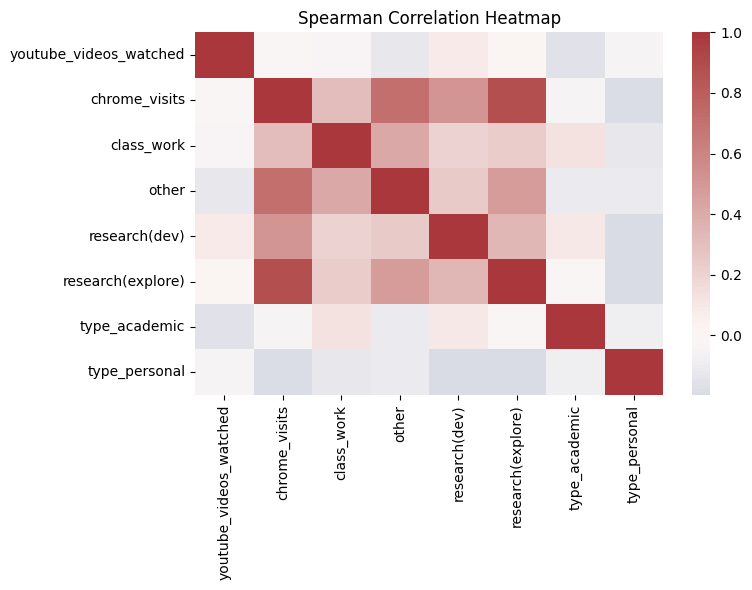

In [33]:
# Spearman’s rho correlation matrix
corr_cols = (
    ['youtube_videos_watched','chrome_visits']
    + unique_types
    + ['type_academic','type_personal']
)
corr_matrix = df[corr_cols].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, center=0, cmap='vlag')
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()

### Cross Correlation Function

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def cross_corr_lags(x, y, maxlag):
    """
    Compute Pearson r(x_t, y_{t+lag}) for lag in [-maxlag..+maxlag].
    Returns (lags, r_values).
    """
    lags = np.arange(-maxlag, maxlag+1)
    r_vals = []
    for lag in lags:
        # shift y **backwards** by lag so that y.shift(-lag)[t] = y[t+lag]
        y_shifted = y.shift(-lag)
        # drop NaNs that arise from shifting
        valid = x.notna() & y_shifted.notna()
        r = x[valid].corr(y_shifted[valid])
        r_vals.append(r)
    return lags, np.array(r_vals)



#### Academic 

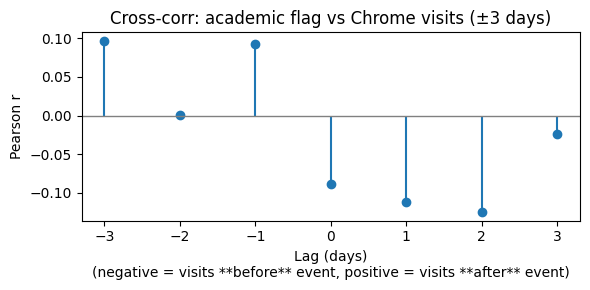

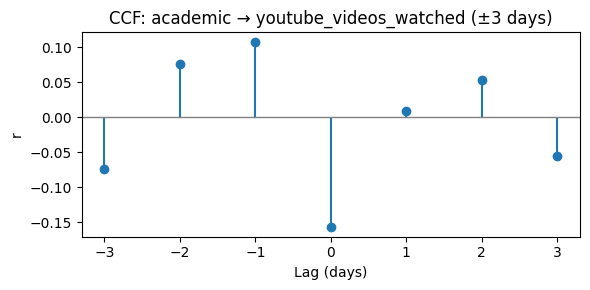

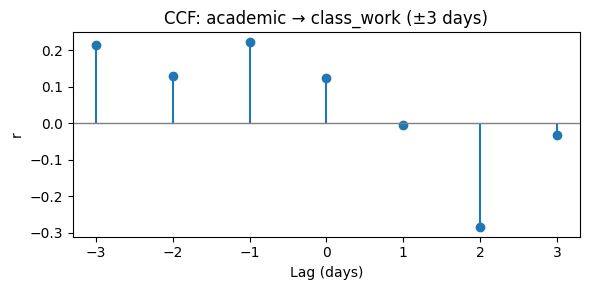

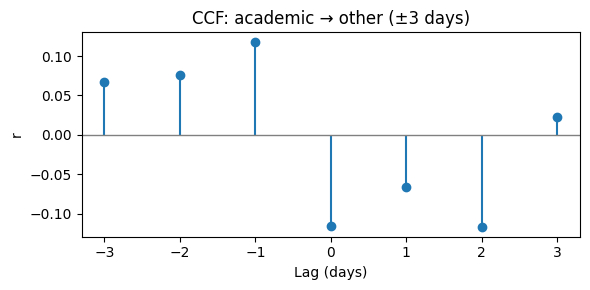

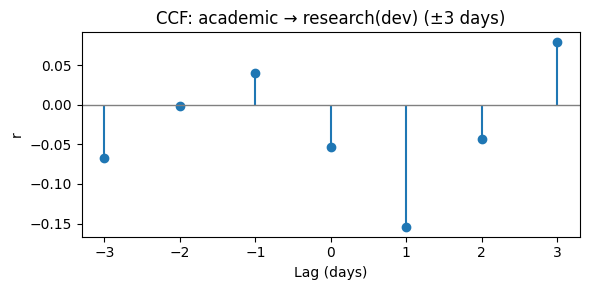

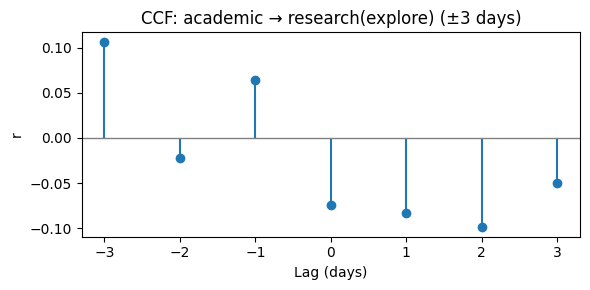

In [50]:
maxlag = 3
x = df['type_academic']
y = df['chrome_visits']

lags, r_vals = cross_corr_lags(x, y, maxlag)

plt.figure(figsize=(6,3))
plt.stem(lags, r_vals, basefmt=" ")
plt.axhline(0, color='gray', linewidth=1)
plt.xlabel('Lag (days)\n(negative = visits **before** event, positive = visits **after** event)')
plt.ylabel('Pearson r')
plt.title(f'Cross-corr: academic flag vs Chrome visits (±{maxlag} days)')
plt.tight_layout()

for col in ['youtube_videos_watched'] + unique_types:
    x = df['type_academic']
    y = df[col]
    lags, r_vals = cross_corr_lags(x, y, maxlag=maxlag)
    plt.figure(figsize=(6,3))
    plt.stem(lags, r_vals, basefmt=" ")
    plt.title(f'CCF: academic → {col} (±{maxlag} days)')
    plt.axhline(0, color='gray', linewidth=1)
    plt.xlabel('Lag (days)')
    plt.ylabel('r')
    plt.tight_layout()
    plt.show()

#### Personal

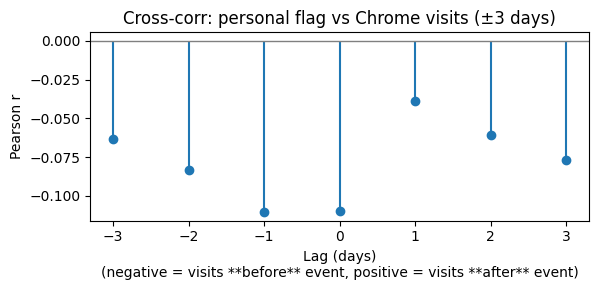

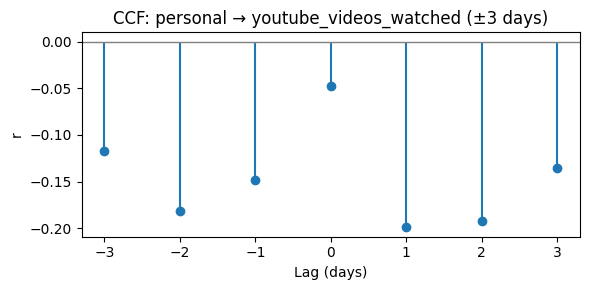

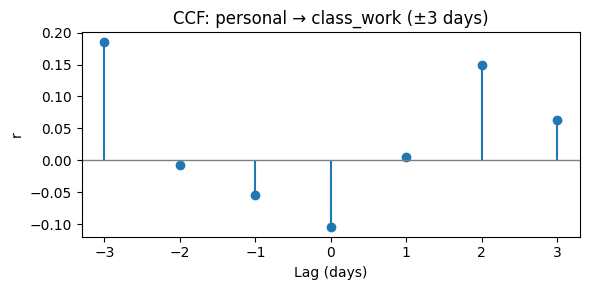

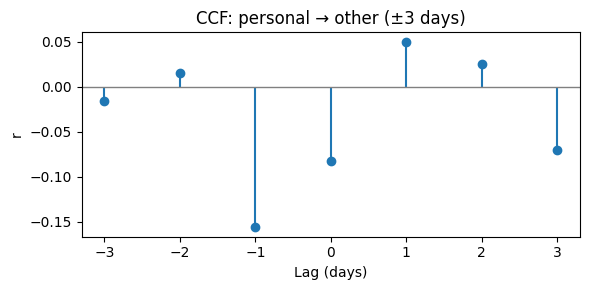

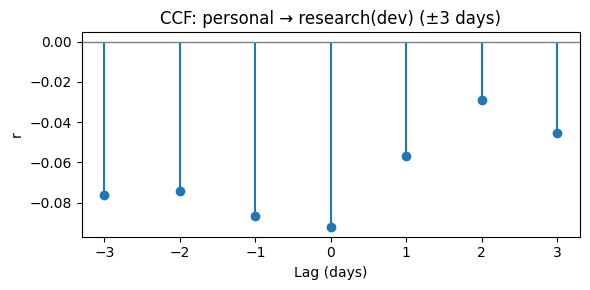

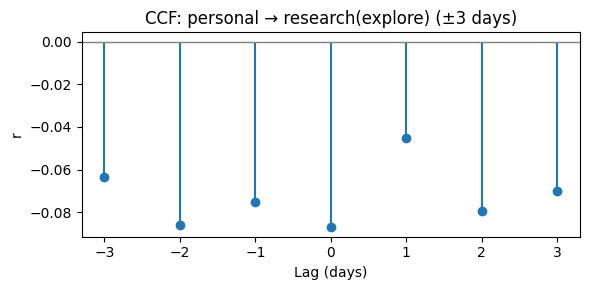

In [52]:
maxlag = 3
x = df['type_personal']
y = df['chrome_visits']

lags, r_vals = cross_corr_lags(x, y, maxlag)

plt.figure(figsize=(6,3))
plt.stem(lags, r_vals, basefmt=" ")
plt.axhline(0, color='gray', linewidth=1)
plt.xlabel('Lag (days)\n(negative = visits **before** event, positive = visits **after** event)')
plt.ylabel('Pearson r')
plt.title(f'Cross-corr: personal flag vs Chrome visits (±{maxlag} days)')
plt.tight_layout()

for col in ['youtube_videos_watched'] + unique_types:
    x = df['type_personal']
    y = df[col]
    lags, r_vals = cross_corr_lags(x, y, maxlag=maxlag)
    plt.figure(figsize=(6,3))
    plt.stem(lags, r_vals, basefmt=" ")
    plt.title(f'CCF: personal → {col} (±{maxlag} days)')
    plt.axhline(0, color='gray', linewidth=1)
    plt.xlabel('Lag (days)')
    plt.ylabel('r')
    plt.tight_layout()
    plt.show()

## Regression

In [53]:
# --- 5. Regression / Predictive Modeling ---
# Logistic regression: predict academic day from activity
X = df[['youtube_videos_watched','chrome_visits']]
# X = df[['youtube_videos_watched','chrome_visits'] + top10]
y = df['type_academic']
logreg = LogisticRegression(max_iter=1000).fit(X, y)
print("Logistic Regression coefficients (academic pred):\n", 
      pd.Series(logreg.coef_[0], index=X.columns).sort_values())
# Logistic regression: predict academic day from activity
X = df[['youtube_videos_watched','chrome_visits']]
# X = df[['youtube_videos_watched','chrome_visits'] + top10]
y = df['type_personal']
logreg = LogisticRegression(max_iter=1000).fit(X, y)
print("Logistic Regression coefficients (personal pred):\n", 
      pd.Series(logreg.coef_[0], index=X.columns).sort_values())

# Linear regression: effect of academic flag on YouTube views
linreg = LinearRegression().fit(df[['type_academic']], df['youtube_videos_watched'])
print(f"Linear effect of academic day on YouTube views: β = {linreg.coef_[0]:.3f}")

linreg = LinearRegression().fit(df[['type_personal']], df['youtube_videos_watched'])
print(f"Linear effect of personal day on YouTube views: β = {linreg.coef_[0]:.3f}")

linreg = LinearRegression().fit(df[['type_academic']], df['chrome_visits'])
print(f"Linear effect of academic day on Chrome visits: β = {linreg.coef_[0]:.3f}")

linreg = LinearRegression().fit(df[['type_personal']], df['chrome_visits'])
print(f"Linear effect of personal day on Chrome visits: β = {linreg.coef_[0]:.3f}")


plt.show()

Logistic Regression coefficients (academic pred):
 youtube_videos_watched   -0.002112
chrome_visits            -0.000783
dtype: float64
Logistic Regression coefficients (personal pred):
 chrome_visits            -0.009461
youtube_videos_watched   -0.001876
dtype: float64
Linear effect of academic day on YouTube views: β = -84.084
Linear effect of personal day on YouTube views: β = -57.024
Linear effect of academic day on Chrome visits: β = -101.574
Linear effect of personal day on Chrome visits: β = -284.492


In [ ]:
# import pandas as pd
# import numpy as np
# from datetime import date
# from scipy.stats import pointbiserialr
# from statsmodels.tsa.stattools import ccf
# from sklearn.linear_model import LogisticRegression, LinearRegression
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 1. Load your data (replace with your actual load) ---
# # df = pd.read_csv('your_timeseries.csv')
# # For this example, assume df is already in memory:
# #    date | youtube_videos_watched | chrome_visits | top_sites

# # --- your existing event lists ---
# targets = [
#     date(2024, 12, 5),
#     date(2025, 2, 3),
#     date(2025, 2, 10),
#     date(2025, 2, 23),
#     date(2025, 3, 1),
#     date(2025, 3, 21),
#     date(2025, 3, 23),
#     date(2025, 3, 30),
#     date(2025, 3, 31),
#     date(2025, 4, 2),
#     date(2025, 4, 10),
# ]
# event_titles = [
#     "WWW Rebuttal Deadline",
#     "KDD Abstract Deadline",
#     "KDD Paper Deadline",
#     "CS6501 Project 1",
#     "Beginning of Ramadan",
#     "Religious event",
#     "Religious event",
#     "CS6501 Project 2",
#     "End of Ramadan",
#     "CS6501 Presentation",
#     "KDD Rebuttal Deadline",
# ]
# event_types = [
#     "academic","academic","academic",
#     "academic","personal","personal",
#     "personal","academic","personal",
#     "academic","academic"
# ]

# # --- 2. Data Preparation ---
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date').sort_index()

# # Build events DataFrame for your listed targets
# events = pd.DataFrame({
#     'date': pd.to_datetime(targets),
#     'event_title': event_titles,
#     'event_type': event_types
# }).set_index('date')

# # --- NEW: Add every Thursday as an academic event ---
# # Generate all Thursdays in the span of your data
# thursdays = pd.date_range(start=df.index.min(),
#                           end=df.index.max(),
#                           freq='W-THU').normalize()

# # Create a DataFrame of those Thursdays
# events_th = pd.DataFrame({
#     'event_title': ['Advisor Meeting'] * len(thursdays),
#     'event_type':  ['academic'] * len(thursdays)
# }, index=thursdays)

# # Combine, but don’t overwrite any specific events you already defined:
# events = pd.concat([
#     events,
#     events_th[~events_th.index.isin(events.index)]
# ])

# # Now join events back into your main df
# df = df.join(events, how='left')

# # One-hot encode event_title and event_type
# df = pd.concat([
#     df,
#     pd.get_dummies(df['event_title'], prefix='ev'),
#     pd.get_dummies(df['event_type'], prefix='type')
# ], axis=1).fillna(0)

# # Expand top_sites list into columns for top 10 domains
# # 1) get the top 10 overall
# all_domains = df['top_sites'].explode().apply(lambda x: x[0])
# top10 = all_domains.value_counts().head(10).index.tolist()

# def mk_site_dict(lst):
#     d = dict(lst)
#     return {dom: d.get(dom, 0) for dom in top10}

# site_counts = df['top_sites'].apply(mk_site_dict).apply(pd.Series)
# df = pd.concat([df, site_counts], axis=1)

# # --- 3. Correlation Analysis ---
# # Point-biserial: academic days vs continuous metrics
# r_youtube, p_youtube = pointbiserialr(df['type_academic'], df['youtube_videos_watched'])
# r_chrome,  p_chrome  = pointbiserialr(df['type_academic'], df['chrome_visits'])
# print(f"Point-biserial corr (academic vs YouTube): r={r_youtube:.3f}, p={p_youtube:.3f}")
# print(f"Point-biserial corr (academic vs Chrome):  r={r_chrome:.3f}, p={p_chrome:.3f}")

# # Spearman’s rho correlation matrix
# corr_matrix = df[
#     ['youtube_videos_watched','chrome_visits'] + top10 + ['type_academic','type_personal']
# ].corr(method='spearman')

# # Cross-correlation function (lag analysis)
# ccf_vals = ccf(df['type_academic'], df['youtube_videos_watched'])
# lags = np.arange(len(ccf_vals))

KeyError: 'top_sites'